# Analyse Deck Names

In this notebook we'll load Dark Tidings data, figure out which decks are evil twins and which are regular decks. We'll also use a trick from ecology to estimate how many decks are printed.

In [1]:
%load_ext nb_black
import pandas as pd
import numpy as np
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [2]:
deck_data = pd.read_csv(
    "./data/dark_tidings_names.csv", header=None, names=["deck"]
).drop_duplicates()
deck_data.tail()

,deck
105409,"무익하게 빽빽한 자, 브뤼헤"
105410,"설리번의 자손, 모도아슐"
105411,"음악적으로 쌓은 프로게이머, 조"
105412,"벙커의 대검, 바타르"
105413,"신성한 국무장관 ""말라깽이"" 우레아"


<IPython.core.display.Javascript object>

In [3]:
evil_deck_data = pd.read_csv(
    "./data/dark_tidings_evil_names.csv", header=None, names=["deck"]
).drop_duplicates()
evil_deck_data.tail()

,deck
8446,Qascale the Zealous’s Evil Twin
8447,The Thwartive Juror’s Evil Twin
8448,Gemello di Ursula L. la Misteriosa
8449,"Gemello di Kaythen “Spiritella”, Artista della..."
8450,恶之漠然地穴巡视者A·德拉朴脱


<IPython.core.display.Javascript object>

Below we figure out which decks are "Evil Twins" and which their non-evil counterpart would be called. Next, we check if there are any pairs registered already. 

In [4]:
from langdetect import detect_langs
import regex

valid_lang = ["en", "zh-cn", "de", "fr", "it", "es", "ko", "pl", "pt"]


def is_hangul(value):
    if regex.search(r"\p{IsHangul}", value):
        return True
    return False


def find_language(text: str):
    language = None
    score = 0
    detected_lgs = detect_langs(text)
    for dl, s in [(dtl.lang, dtl.prob) for dtl in detected_lgs]:
        if dl in valid_lang:
            if dl == "ko":
                # Extra check as Chinese is often detected as Korean
                language = "ko" if is_hangul(text) else "zh-cn"
            else:
                language = dl
            score = s
            break
    return language, score


evil_prefix = [
    "Evil Twin of ",  # English
    "Gemello di ",  # Italian
    "Le Double Maléfique de ",  # French
    "Reflejo Oscuro de ",  # Spanish
    "Böser Zwilling von ",  # German
    "恶之",  # Chinese
    "邪恶",  # Chinese
    "Gêmeo do Mal de ",  # Portugese
]
evil_suffix = [
    "’s Evil Twin",  # English
    " - Zła Bliźniaczka",  # Polish
    " - Zły Bliźniak",  # Polish
    "的邪恶分身",  # Chinese
    "的邪惡雙生",  # Chinese
    "의 사악한 분신",  # Korean
]


def is_evil_twin(name: str):
    return any(
        [name.startswith(s) for s in evil_prefix]
        + [name.endswith(s) for s in evil_suffix]
    )


def non_evil_name(name: str):
    for s in evil_prefix + evil_suffix:
        name = name.replace(s, "")

    return name


def start_pipeline(df):
    return df.copy()


def detect_evil_twins(df):
    df["evil_twin"] = df["deck"].apply(is_evil_twin)

    return df


def rename_evil_twins(df):
    df["non_evil_name"] = df["deck"].apply(non_evil_name)

    return df


def has_known_evil_twin(df):
    evil_twins = list(df[df.evil_twin].non_evil_name)
    df["known_evil_twin"] = df["deck"].isin(evil_twins)

    return df


def add_language(df):
    languages, scores = [], []

    for d in tqdm(df.deck, desc="Detecting deck languages"):
        language, score = find_language(d)

        languages.append(language)
        scores.append(score)

    df["language"] = languages
    df["language_score"] = scores

    return df


twin_data = (
    deck_data.pipe(start_pipeline)
    .pipe(detect_evil_twins)
    .pipe(rename_evil_twins)
    .pipe(has_known_evil_twin)
    .pipe(add_language)
)
twin_data.head()

Detecting deck languages: 100%|███████████████████████████████████████████████| 105414/105414 [10:28<00:00, 167.71it/s]


,deck,evil_twin,non_evil_name,known_evil_twin,language,language_score
0,The Brawler of Strathpark,False,The Brawler of Strathpark,False,en,0.999999
1,韩国神箭手黎问凝,False,韩国神箭手黎问凝,False,zh-cn,0.999999
2,“盲狙”加蘭德下士,False,“盲狙”加蘭德下士,False,zh-cn,1.000000
3,秦国中郎黄星泽,False,秦国中郎黄星泽,False,zh-cn,0.857143
4,Saufeia G. l’Attenta,False,Saufeia G. l’Attenta,False,de,0.571428


<IPython.core.display.Javascript object>

In [5]:
twin_data.to_csv("./data/twin_data_processed.tab", sep="\t")

<IPython.core.display.Javascript object>

In [6]:
twin_data[twin_data.evil_twin]

,deck,evil_twin,non_evil_name,known_evil_twin,language,language_score
38,"은성 가문의 수호신, 시로온다의 사악한 분신",True,"은성 가문의 수호신, 시로온다",False,ko,1.000000
45,"인간 화가, 그라디우스의 사악한 분신",True,"인간 화가, 그라디우스",False,ko,0.999998
52,Evil Twin of The Sonorous Warden,True,The Sonorous Warden,False,en,0.999998
53,Envious Qacha of the Retreat’s Evil Twin,True,Envious Qacha of the Retreat,False,en,0.999997
68,花園族長里拉的邪惡雙生,True,花園族長里拉,False,zh-cn,0.571428
...,...,...,...,...,...,...
105345,"Le Double Maléfique de V. J. Abel, marquise de...",True,"V. J. Abel, marquise de la foudre",False,fr,0.999995
105351,Reflejo Oscuro de Héroe “Gato Loco” Helswarn,True,Héroe “Gato Loco” Helswarn,False,es,0.857139
105360,"Gemello di Geirsteinn, il Liscio della Pizza R...",True,"Geirsteinn, il Liscio della Pizza Ribelle",False,it,0.999997
105399,"Martina ""Calvin"" Griggs’s Evil Twin",True,"Martina ""Calvin"" Griggs",False,en,0.999995


<IPython.core.display.Javascript object>

In [7]:
twin_data[~twin_data.evil_twin]

,deck,evil_twin,non_evil_name,known_evil_twin,language,language_score
0,The Brawler of Strathpark,False,The Brawler of Strathpark,False,en,0.999999
1,韩国神箭手黎问凝,False,韩国神箭手黎问凝,False,zh-cn,0.999999
2,“盲狙”加蘭德下士,False,“盲狙”加蘭德下士,False,zh-cn,1.000000
3,秦国中郎黄星泽,False,秦国中郎黄星泽,False,zh-cn,0.857143
4,Saufeia G. l’Attenta,False,Saufeia G. l’Attenta,False,de,0.571428
...,...,...,...,...,...,...
105409,"무익하게 빽빽한 자, 브뤼헤",False,"무익하게 빽빽한 자, 브뤼헤",False,ko,0.999999
105410,"설리번의 자손, 모도아슐",False,"설리번의 자손, 모도아슐",False,ko,0.999998
105411,"음악적으로 쌓은 프로게이머, 조",False,"음악적으로 쌓은 프로게이머, 조",False,ko,0.999999
105412,"벙커의 대검, 바타르",False,"벙커의 대검, 바타르",False,ko,1.000000


<IPython.core.display.Javascript object>

In [8]:
twin_data[twin_data.known_evil_twin]

,deck,evil_twin,non_evil_name,known_evil_twin,language,language_score
11,Lord Huet,False,Lord Huet,True,None,0.000000
46,Citizen Khidell J. Leroy,False,Citizen Khidell J. Leroy,True,it,0.571427
58,Alcott “Gestora Cosquillas” Nobody,False,Alcott “Gestora Cosquillas” Nobody,True,es,0.857139
90,Shady Latifang,False,Shady Latifang,True,en,0.285714
105,"소름끼치는 장사 ""카멜레온"" 오로라",False,"소름끼치는 장사 ""카멜레온"" 오로라",True,ko,1.000000
...,...,...,...,...,...,...
105297,"베일러 가문의 재벌, 헬지버스트",False,"베일러 가문의 재벌, 헬지버스트",True,ko,0.999998
105298,Shrikesfen’s Prolific Warlord,False,Shrikesfen’s Prolific Warlord,True,en,0.999995
105313,“鷹眼修女”西拉·柯恩,False,“鷹眼修女”西拉·柯恩,True,zh-cn,0.999999
105334,보드게이머의 커피숍에서 온 랑엘릭스,False,보드게이머의 커피숍에서 온 랑엘릭스,True,ko,1.000000


<IPython.core.display.Javascript object>

There is a trick in ecology to estimate the size of a population by first catching a number of individuals and marking them on a certain day. The next day, you start catching individuals again and check how many are marked. If you caught and marked 50 animals on the first day, and you catch 100 the next, of which 10 are marked, you know that on day one you caught 10 % of the entire population. Hence the total population size is 50 * 100/10. This is called the [Mark and Recapture](https://en.wikipedia.org/wiki/Mark_and_recapture) technique. We can do the same with Dark Tidings decks because of the presense of Evil Twin decks !

In [9]:
evil_decks = twin_data[twin_data.evil_twin].shape[0]
non_evil_decks = twin_data[~twin_data.evil_twin].shape[0]
pairs_found = twin_data[twin_data.known_evil_twin].shape[0]

print(
    f"There are {pairs_found} twin pairs found between {evil_decks} evil and {non_evil_decks} non-evil decks."
)

There are 2854 twin pairs found between 8454 evil and 96960 non-evil decks.


<IPython.core.display.Javascript object>

In [10]:
total_non_evil_estimate = int(evil_decks * (non_evil_decks / pairs_found))
total_evil_estimate = int(total_non_evil_estimate * evil_decks / non_evil_decks)

print(
    f"There were approx. {total_non_evil_estimate} non-evil decks printed and {total_evil_estimate} evil ones, so there is a {evil_decks * 100/(evil_decks + non_evil_decks):.2f} % chance to get an Evil Twin."
)
print(
    f"So the total estimated dark tidings decks printed is {total_non_evil_estimate + total_evil_estimate}."
)
print(
    f"Currently about {(100 * (evil_decks+non_evil_decks)/(total_evil_estimate + total_non_evil_estimate)):.2f} % was included in this analysis."
)

There were approx. 287210 non-evil decks printed and 25042 evil ones, so there is a 8.02 % chance to get an Evil Twin.
So the total estimated dark tidings decks printed is 312252.
Currently about 33.76 % was included in this analysis.


<IPython.core.display.Javascript object>

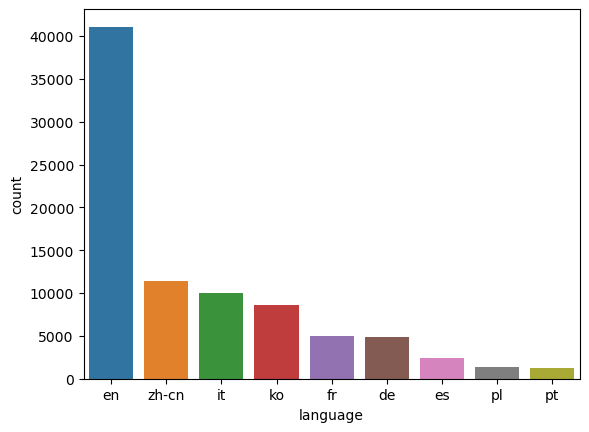

<IPython.core.display.Javascript object>

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = (
    twin_data[twin_data.language_score > 0.8]
    .groupby("language")
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .sort_values("count", ascending=False)
)

sns.barplot(data=plot_df, x="language", y="count")
plt.show()

In [61]:
import pymc3 as pm

n1 = evil_decks
n2 = non_evil_decks
n12 = pairs_found

with pm.Model() as model:
    N_ = pm.Bound(pm.Flat, lower=n1 + n2 - n12)("N")
    p = pm.Deterministic("p", n1 / N_)

    N_corrected = pm.Deterministic("N_corrected", N_ * (n1 + n2) / (n2))
    percentage_registered = pm.Deterministic(
        "percentage_registered", (n1 + n2) * 100 / N_corrected
    )

    n12_obs = pm.Binomial("n12_obs", n2, p, observed=n12)

<IPython.core.display.Javascript object>

In [62]:
with model:
    trace = pm.sample(4000, target_accept=0.9)

<ipython-input-62-069a269a3ba0>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(4000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [N]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

<Figure size 700x700 with 0 Axes>

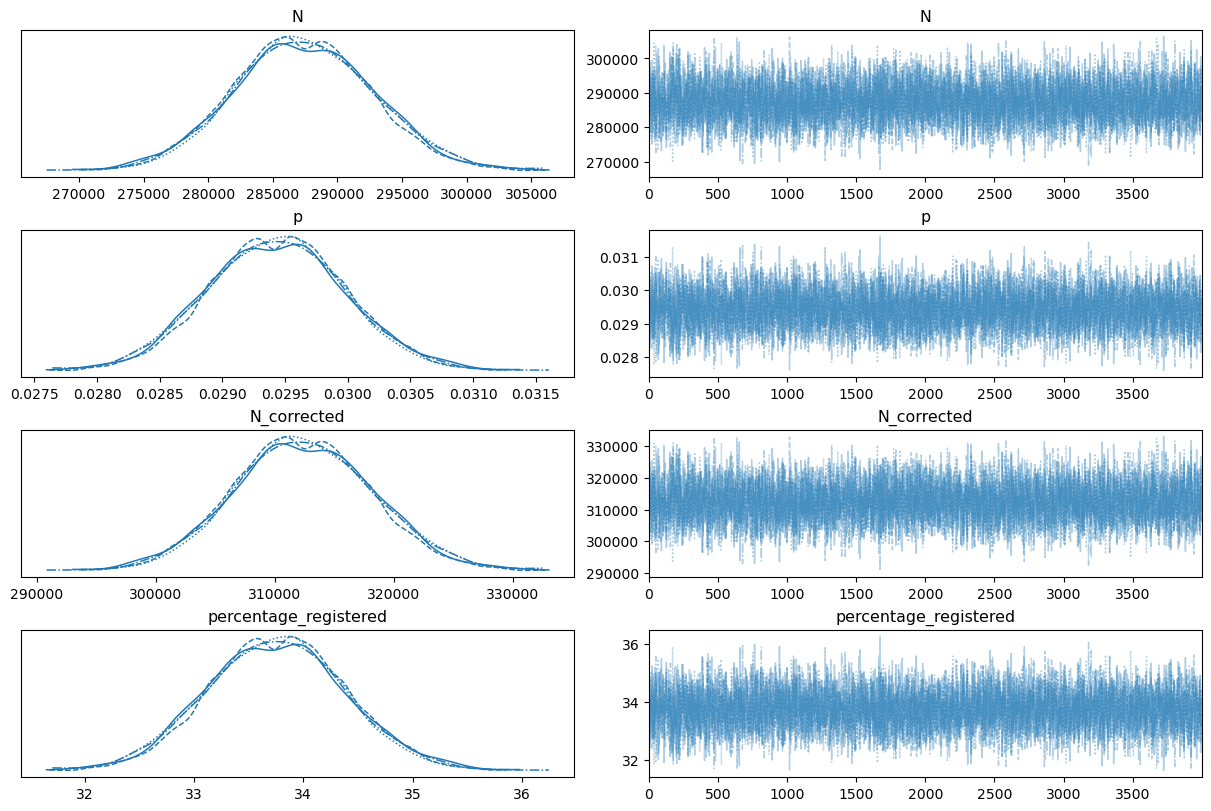

<IPython.core.display.Javascript object>

In [63]:
with model:
    plt.figure(figsize=(7, 7))
    pm.plot_trace(trace)
    plt.show()

In [55]:
with pm.Model() as model_2:
    N_ = pm.Bound(pm.Flat, lower=n1 + n2 - n12)("N")
    p = pm.Deterministic("p", n1 / N_)

    evil_probability = pm.Beta("evil_probability", 1, 1) # flat prior for probability of getting an Evil twin deck
    evil_obs = pm.Binomial("evil_obs", (n1 + n2), evil_probability, observed=n1)

    N_corrected = pm.Deterministic("N_corrected", N_ * (1 + evil_probability))

    percentage_registered = pm.Deterministic(
        "percentage_registered", (n1 + n2) * 100 / N_corrected
    )

    n12_obs = pm.Binomial("n12_obs", n2, p, observed=n12)

<IPython.core.display.Javascript object>

In [56]:
with model_2:
    trace_2 = pm.sample(4000, target_accept=0.9)

<ipython-input-56-6112193638fe>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample(4000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [evil_probability, N]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

<Figure size 700x700 with 0 Axes>

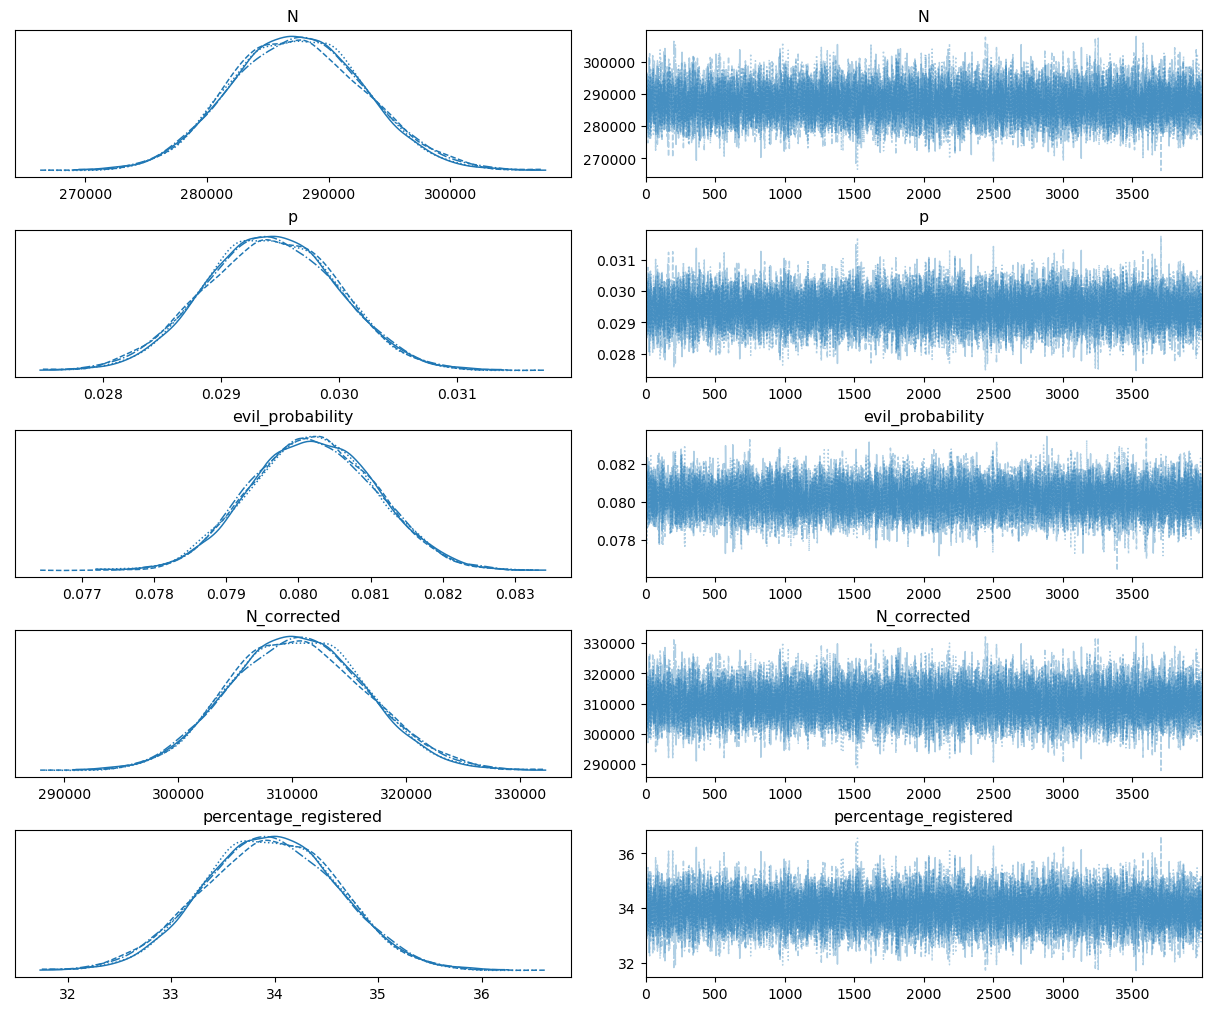

<IPython.core.display.Javascript object>

In [57]:
with model_2:
    plt.figure(figsize=(7, 7))
    pm.plot_trace(trace_2)
    plt.show()

In [60]:
with model_2:
    stats_df = pm.summary(trace_2, kind="stats")
stats_df

,mean,sd,hdi_3%,hdi_97%
N,287455.022,5449.779,277617.883,297901.771
p,0.029,0.001,0.028,0.030
evil_probability,0.080,0.001,0.079,0.082
N_corrected,310509.726,5891.376,299581.466,321465.278
percentage_registered,33.961,0.644,32.792,35.187


<IPython.core.display.Javascript object>